In [8]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..") # Adds higher directory to python modules path.

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import time
import warnings
warnings.filterwarnings("ignore")
from locanmf import LocaNMF
import postprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
## [OPTIONAL] if cuda support, uncomment following lines
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# device='cuda'

# else, if on cpu
device='cpu'

# User-defined Parameters

In [11]:
minrank = 1; maxrank = 1; # rank = how many components per brain region. Set maxrank to around 10 for regular dataset.
rank_range = (minrank, maxrank, 1)
min_pixels = 100 # minimum number of pixels in Allen map for it to be considered a brain region
loc_thresh = 70 # Localization threshold, i.e. percentage of area restricted to be inside the 'Allen boundary'
r2_thresh = 0.99 # Fraction of variance in the data to capture with LocaNMF
nonnegative_temporal = False # Do you want nonnegative temporal components? The data itself should also be nonnegative in this case.


# Load & Format Data

In [12]:
# Folder where the data is stored
datafolder='./data/simulated/'
# # For Nonnegative Data, uncomment the following lines, ex. if you want nonnegative temporal components
# datafolder='./data/simulated_nonnegative/'

# File 'Vc_Uc.mat' in the above folder contains 'Uc', 'Vc', 'brainmask'. Simulated data also contains 'trueareas'.
arrays=sio.loadmat(datafolder+'Vc_Uc.mat')

atlas = sio.loadmat(datafolder+'atlas.mat')['atlas'].astype(float)
areanames = sio.loadmat(datafolder+'atlas.mat')['areanames']

In [13]:
# Get data in the correct format
V=arrays['Vc']
U=arrays['Uc']
brainmask=arrays['brainmask']==1
trueareas=arrays['trueareas'].flatten()
del arrays

Rank of video : 58
Number of timepoints : 10000


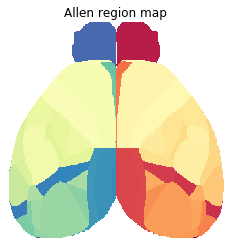

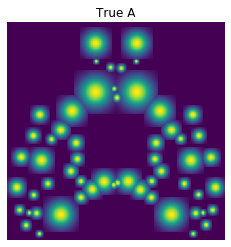

In [14]:
# Check that data has the correct shapes. V [K_d x T], U [X x Y x K_d], brainmask [X x Y]
if V.shape[0]!=U.shape[-1]: print('Wrong dimensions of U and V!')
print("Rank of video : %d" % V.shape[0]); print("Number of timepoints : %d" % V.shape[1]); 

# Plot the maximum U for each pixel
plotmap=np.zeros((atlas.shape)); plotmap.fill(np.nan); plotmap[brainmask]=atlas[brainmask]
plt.imshow(plotmap,cmap='Spectral'); plt.axis('off'); plt.title('Allen region map'); plt.show(); 
plt.imshow(np.max(U,axis=2)); plt.axis('off'); plt.title('True A'); plt.show()

In [15]:
# Perform the LQ decomposition. Time everything.
t0_global = time.time()
t0 = time.time()
if nonnegative_temporal:
    r = V.T
else:
    q, r = np.linalg.qr(V.T)
time_ests={'qr_decomp':time.time() - t0}

# Initialize LocaNMF

In [16]:
# Put in data structure for LocaNMF
video_mats = (np.copy(U[brainmask]), r.T)
del U

In [17]:
# region_mats[0] = [unique regions x pixels] the mask of each region
# region_mats[1] = [unique regions x pixels] the distance penalty of each region
# region_mats[2] = [unique regions] area code
region_mats = LocaNMF.extract_region_metadata(brainmask, atlas, min_size=min_pixels)

In [18]:
region_metadata = LocaNMF.RegionMetadata(region_mats[0].shape[0],
                                           region_mats[0].shape[1:],
                                           device=device)

region_metadata.set(torch.from_numpy(region_mats[0].astype(np.uint8)),
                    torch.from_numpy(region_mats[1]),
                    torch.from_numpy(region_mats[2].astype(np.int64)))

In [19]:
# Do SVD
if device=='cuda': torch.cuda.synchronize()
print('v SVD Initialization')
t0 = time.time()
region_videos = LocaNMF.factor_region_videos(video_mats,
                                               region_mats[0],
                                               rank_range[1],
                                               device=device)
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['svd_init'] = time.time() - t0

v SVD Initialization
'-total : 0.292835


In [20]:
low_rank_video = LocaNMF.LowRankVideo(
    (int(np.sum(brainmask)),) + video_mats[1].shape, device=device
)
low_rank_video.set(torch.from_numpy(video_mats[0].T),
                   torch.from_numpy(video_mats[1]))

# LocaNMF

In [21]:
if device=='cuda': torch.cuda.synchronize()
print('v Rank Line Search')
t0 = time.time()
locanmf_comps = LocaNMF.rank_linesearch(low_rank_video,
                                            region_metadata,
                                            region_videos,
                                            maxiter_rank=maxrank-minrank+1,
                                            maxiter_lambda=20, 
                                            maxiter_hals=20,
                                            lambda_step=1.35,
                                            lambda_init=1e-6, 
                                            loc_thresh=loc_thresh,
                                            r2_thresh=r2_thresh,
                                            rank_range=rank_range,
                                            nnt=nonnegative_temporal,
                                            verbose=[True, False, False],
                                            sample_prop=(1,1),
                                            device=device
                                         )
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['rank_linesearch'] = time.time() - t0

v Rank Line Search
|--v Rank Line Search Iteration 0
|  |--v Initialization
|  |  '-total : 0.058756 seconds
|  |--v Lambda Line Search
|  |  '- 20 iterations took 145.05 seconds
|  |--> R2 Evaluation took 9.05991e-06 seconds
|  '-total : 145.109 seconds
'-total : 145.419811


In [22]:
print("Number of components : %d" % len(locanmf_comps))

Number of components : 58


In [23]:
# Evaluate R^2
_,r2_fit=LocaNMF.evaluate_fit_to_region(low_rank_video,
                                           locanmf_comps,
                                           region_metadata.support.data.sum(0),
                                           sample_prop=(1, 1))
print("R^2 fit on all data : %f" % r2_fit)

time_ests['global_time'] = time.time()-t0_global

R^2 fit on all data : 0.999973


# Reformat spatial and temporal matrices, plot, and save

In [24]:
# Assigning regions to components
region_ranks = []; region_idx = []

for rdx in torch.unique(locanmf_comps.regions.data, sorted=True):
    region_ranks.append(torch.sum(rdx == locanmf_comps.regions.data).item())
    region_idx.append(rdx.item())

areas=region_metadata.labels.data[locanmf_comps.regions.data].cpu().numpy()

In [25]:
# Get LocaNMF spatial and temporal components
A=locanmf_comps.spatial.data.cpu().numpy().T
A_reshape=np.zeros((brainmask.shape[0],brainmask.shape[1],A.shape[1])); A_reshape.fill(np.nan)
A_reshape[brainmask,:]=A

if nonnegative_temporal:
    C=locanmf_comps.temporal.data.cpu().numpy()
else:
    C=np.matmul(q,locanmf_comps.temporal.data.cpu().numpy().T).T

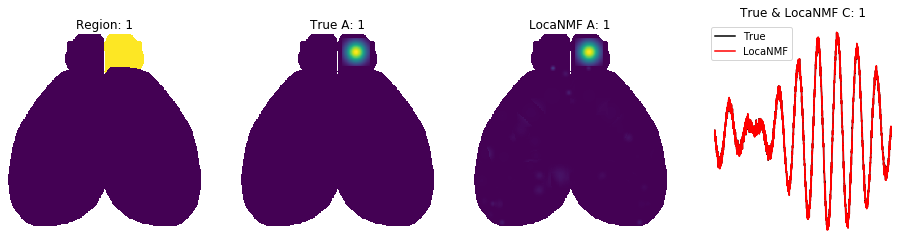

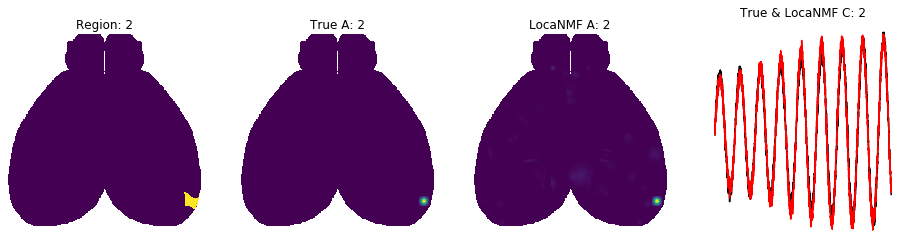

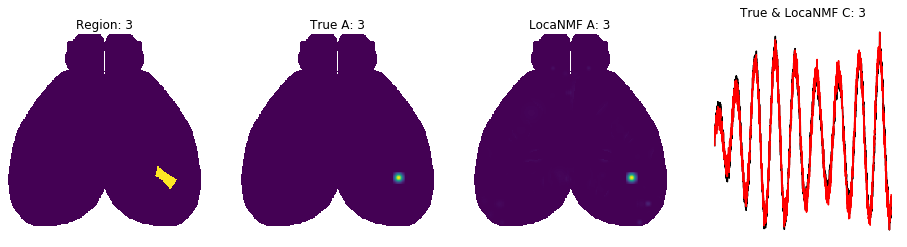

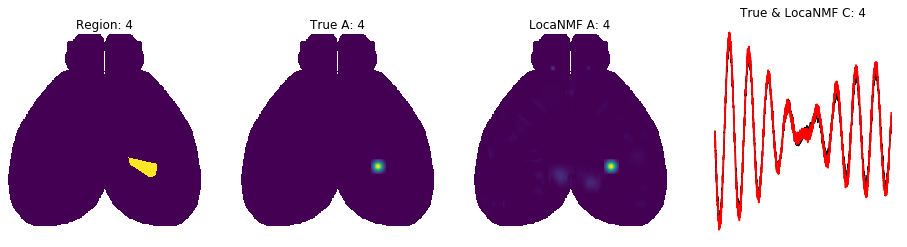

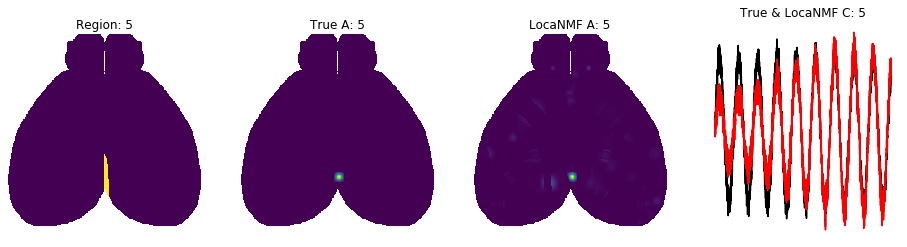

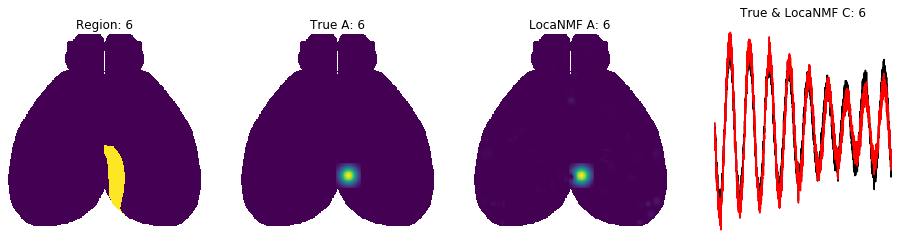

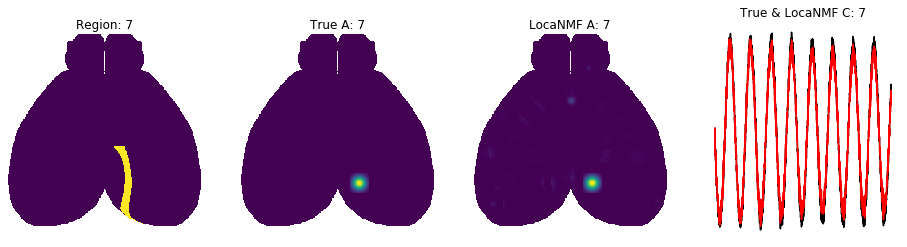

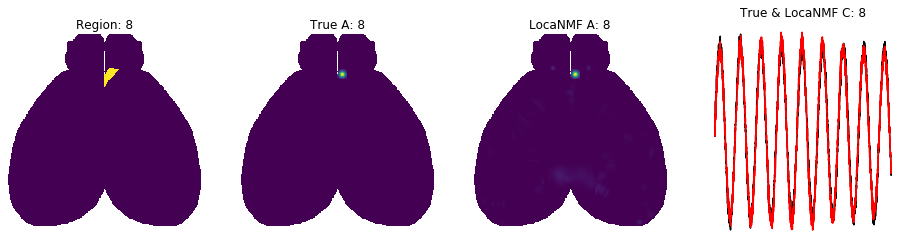

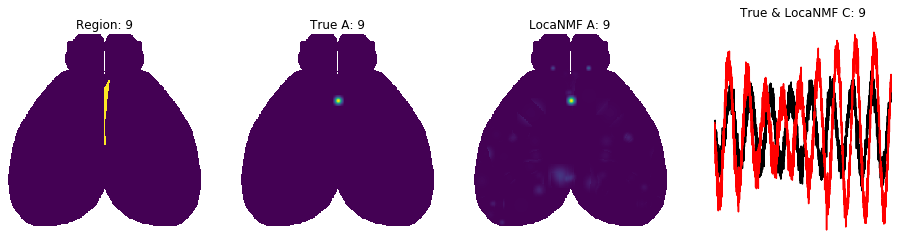

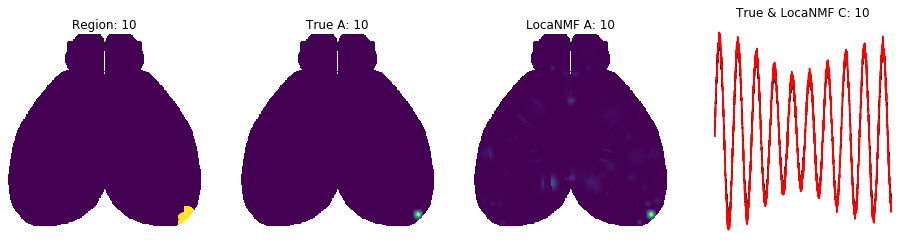

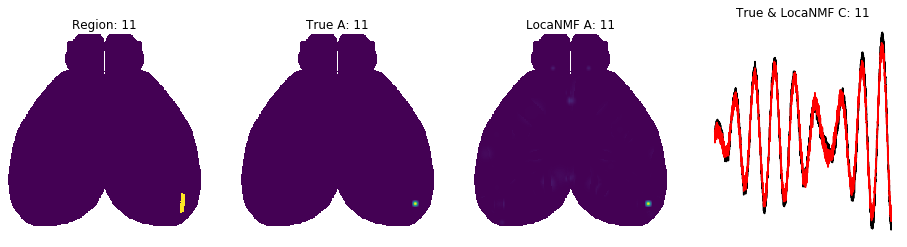

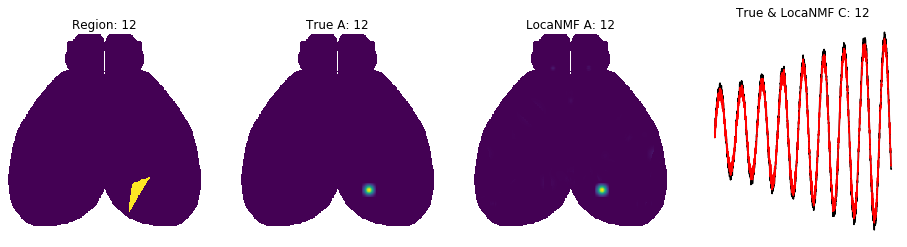

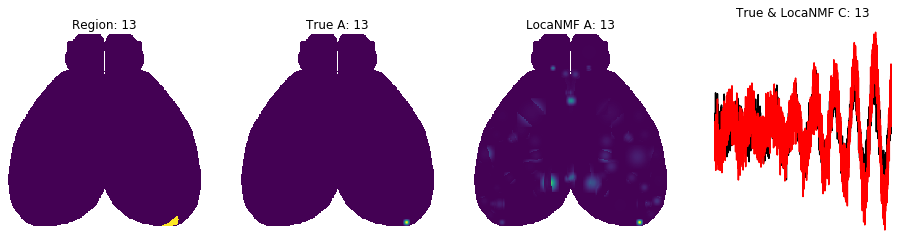

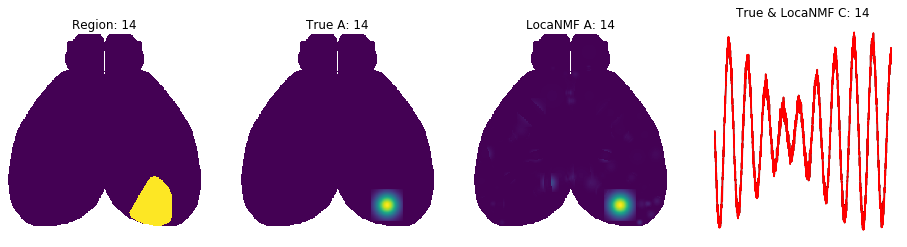

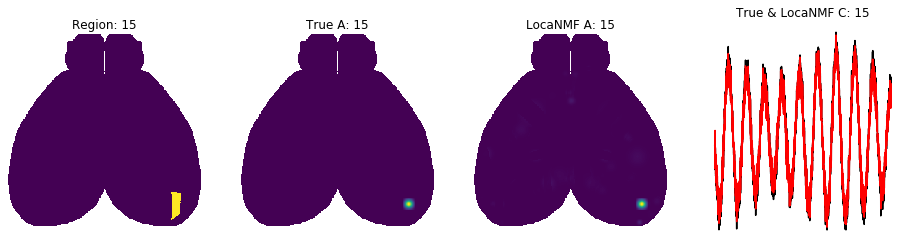

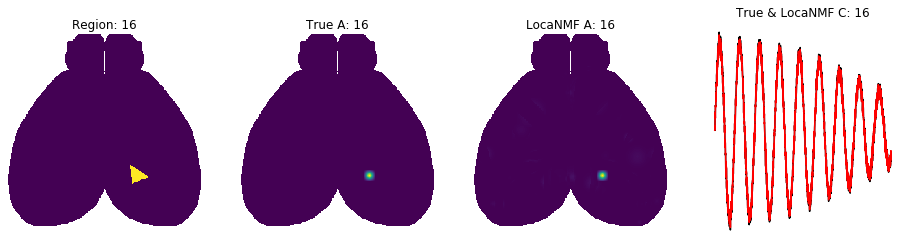

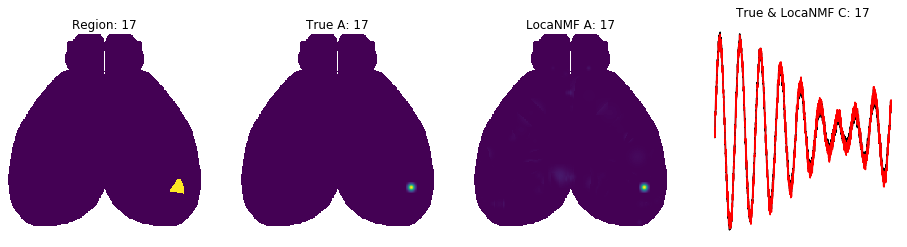

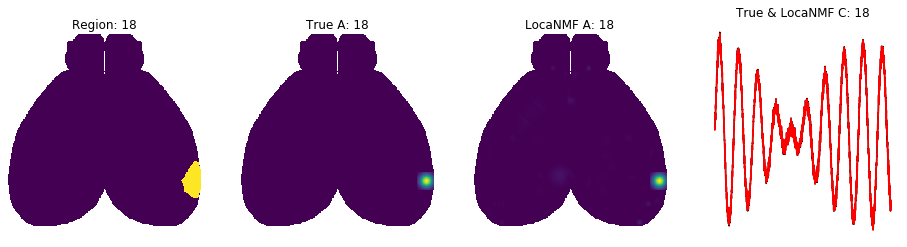

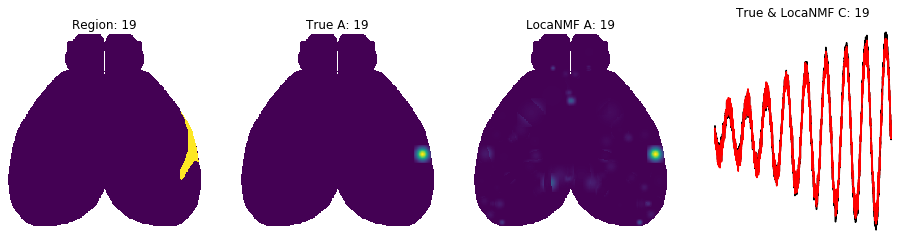

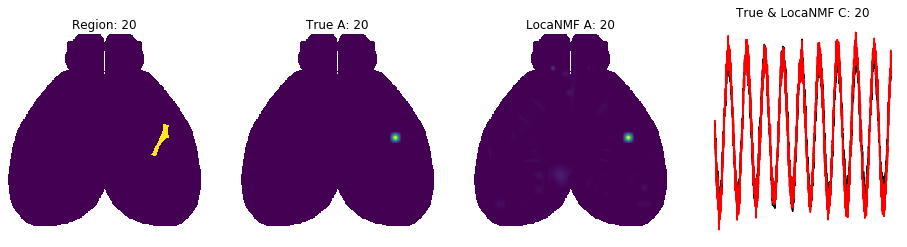

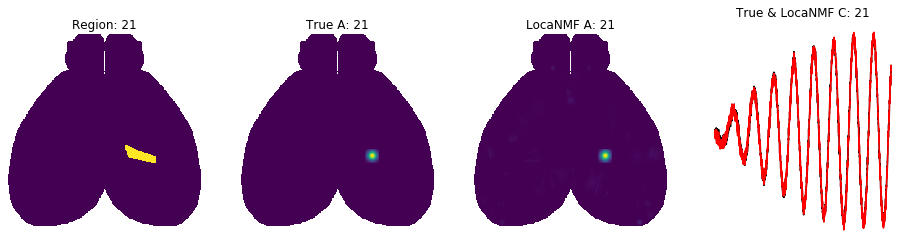

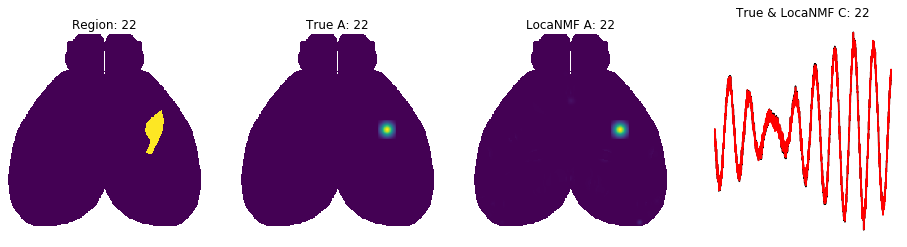

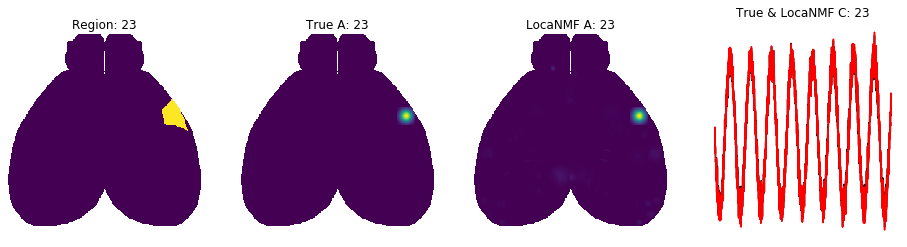

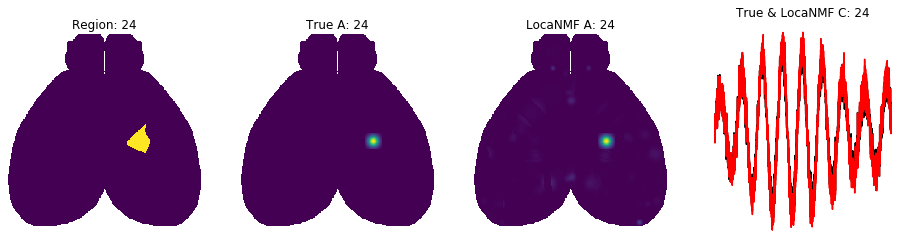

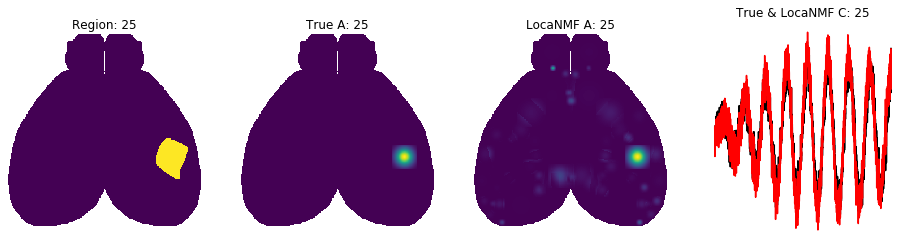

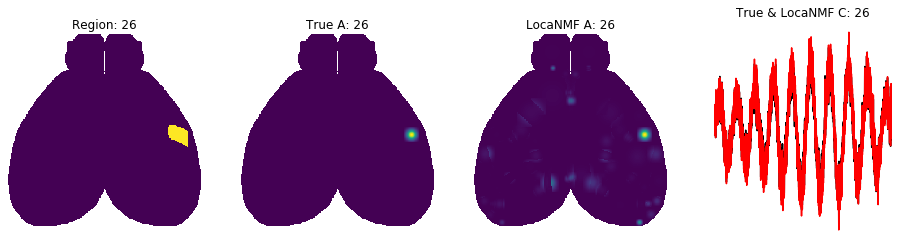

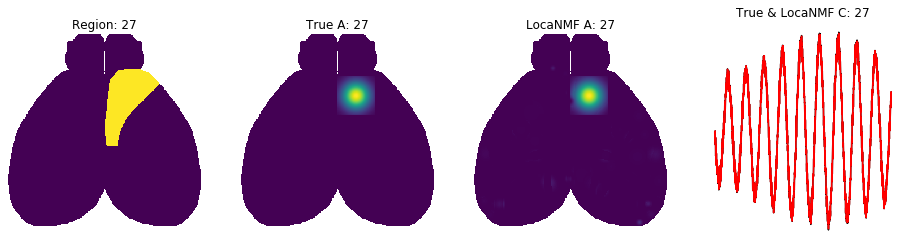

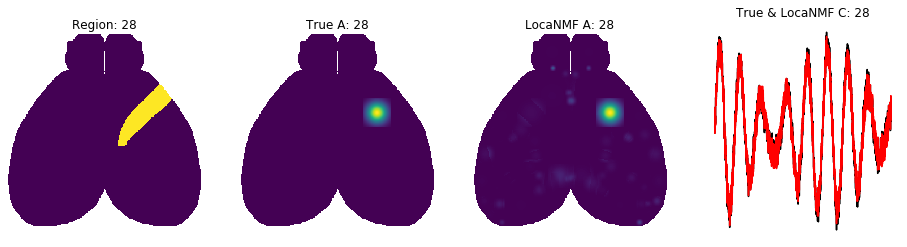

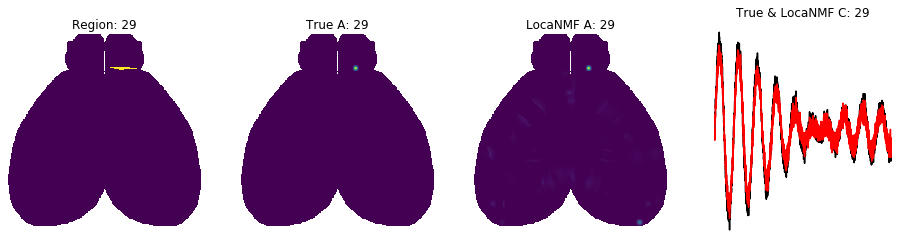

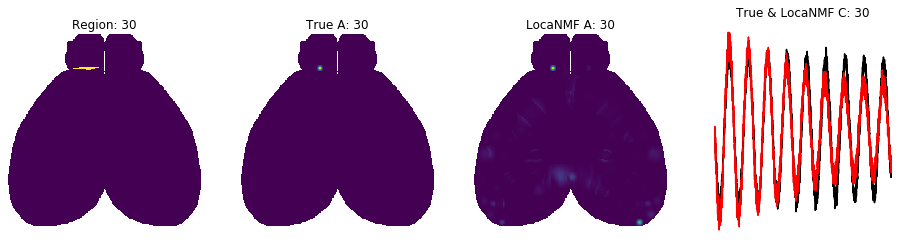

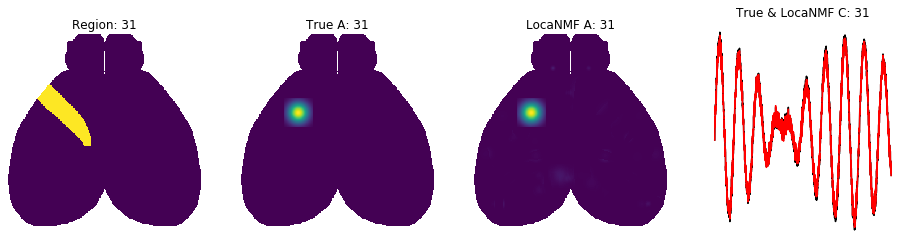

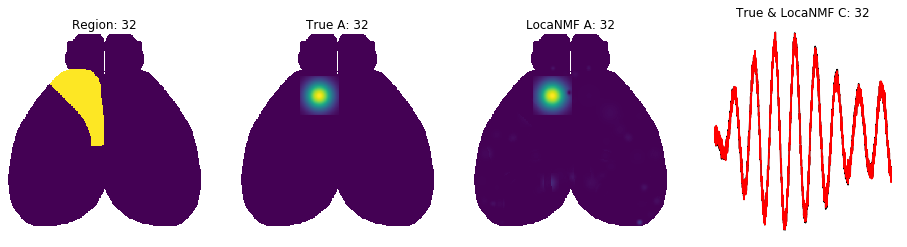

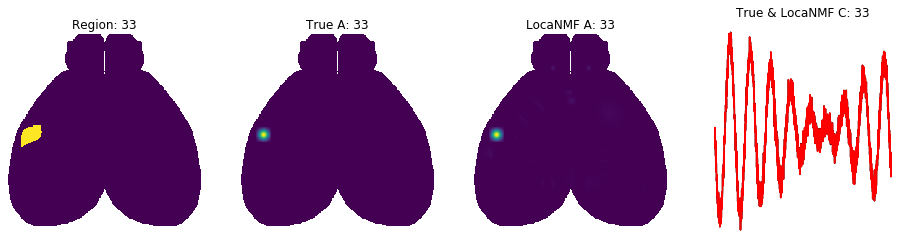

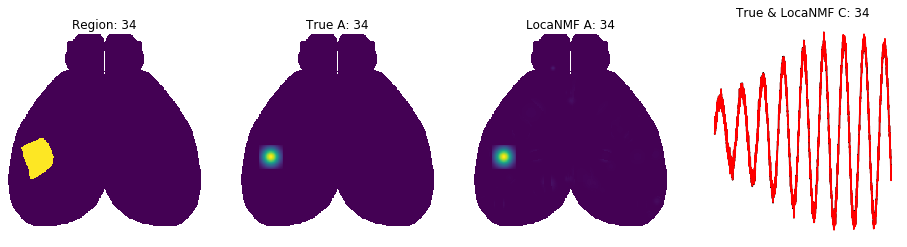

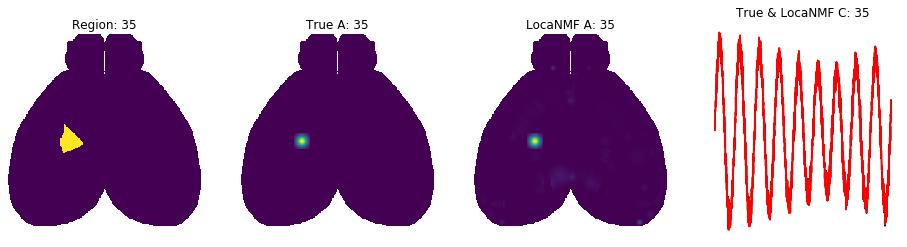

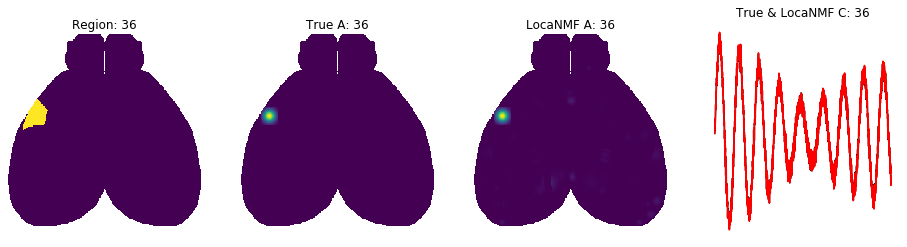

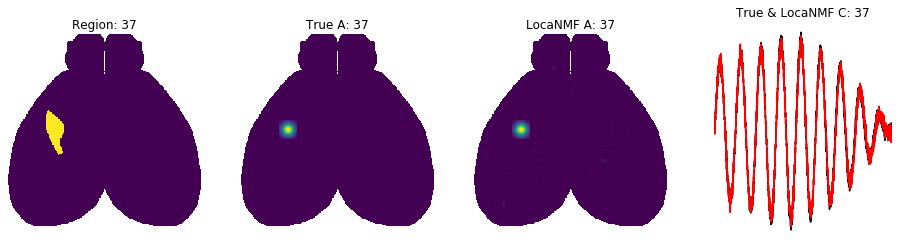

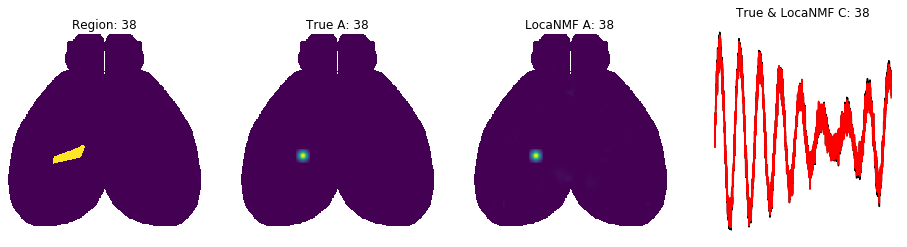

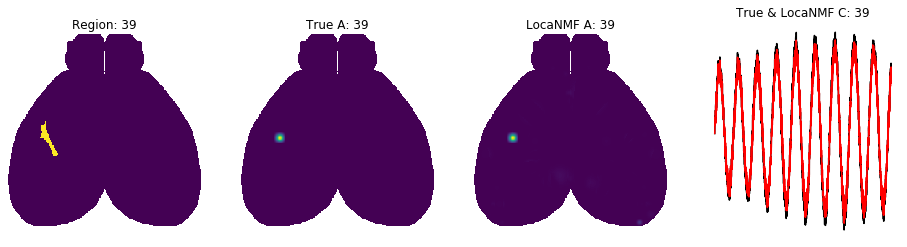

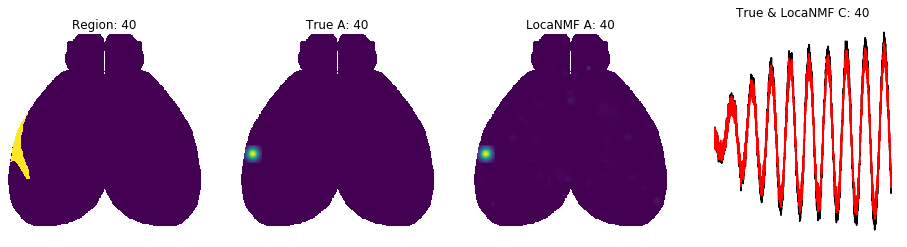

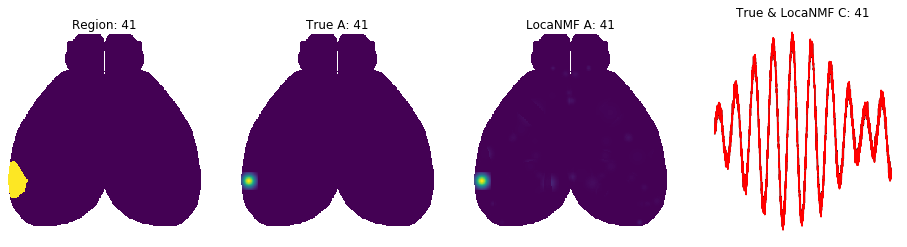

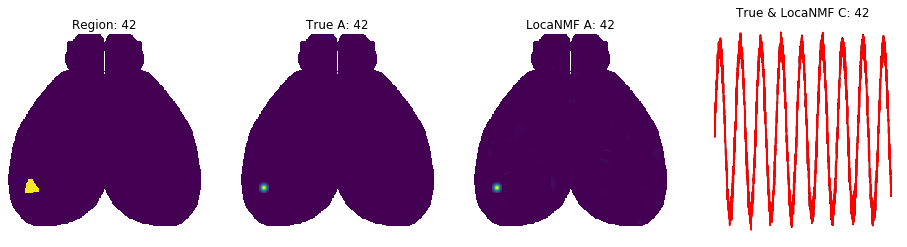

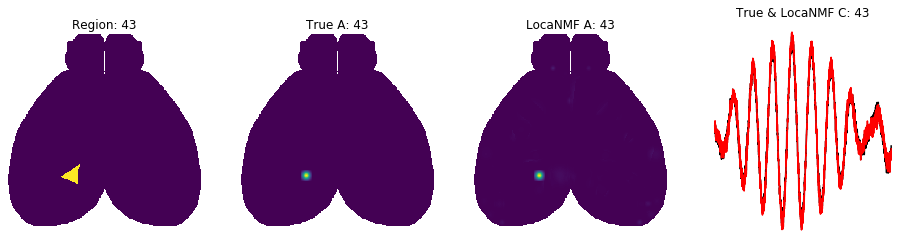

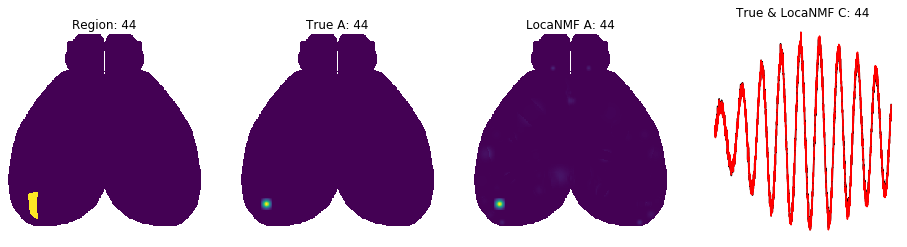

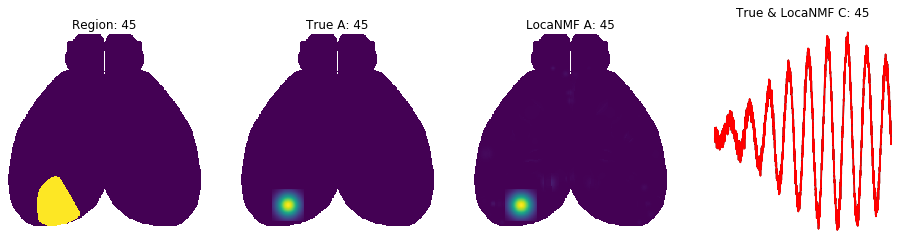

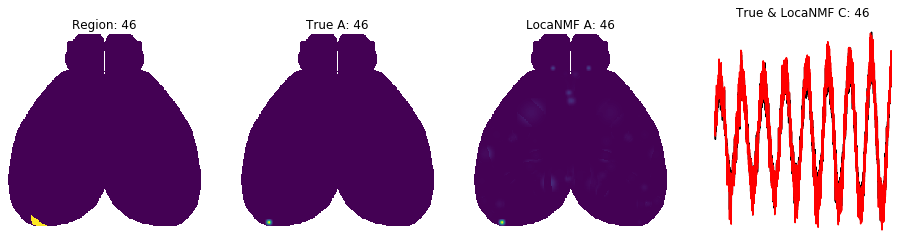

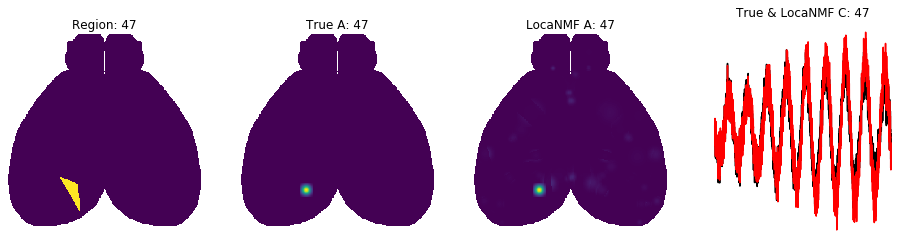

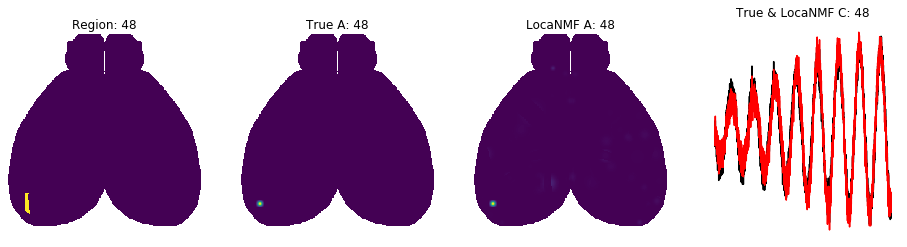

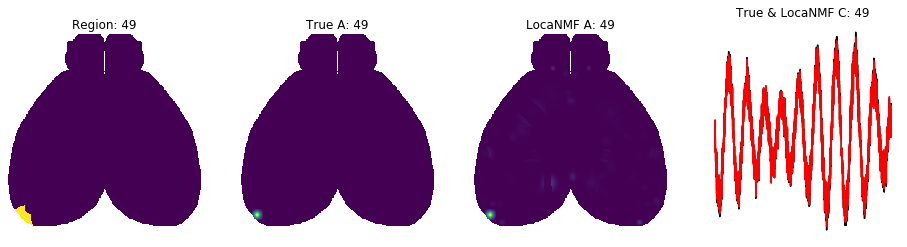

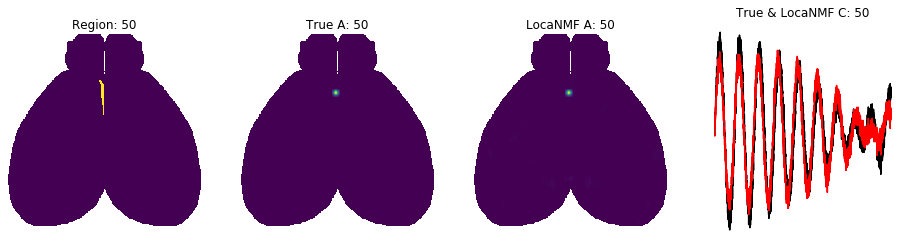

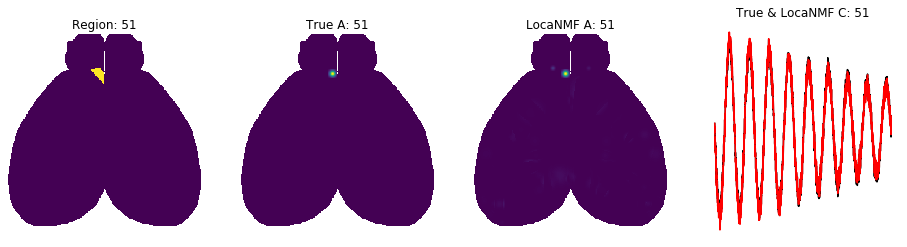

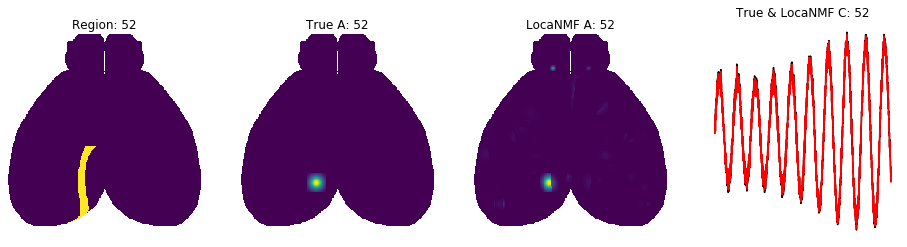

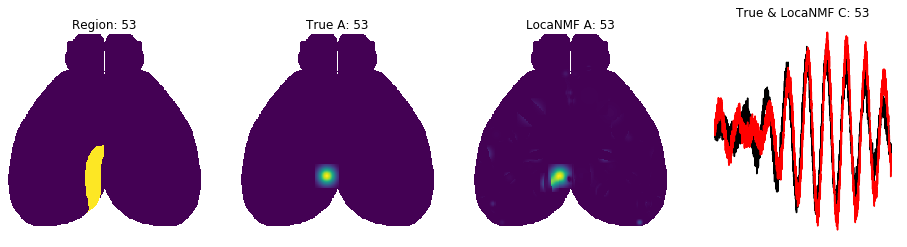

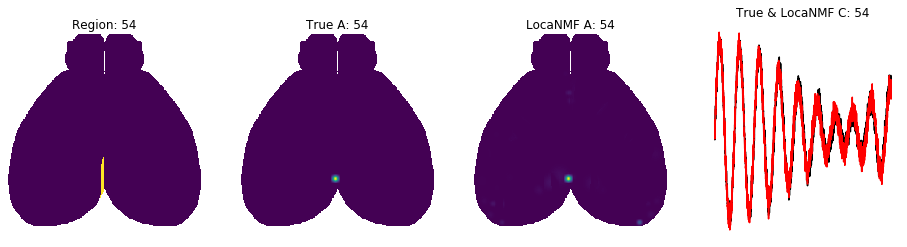

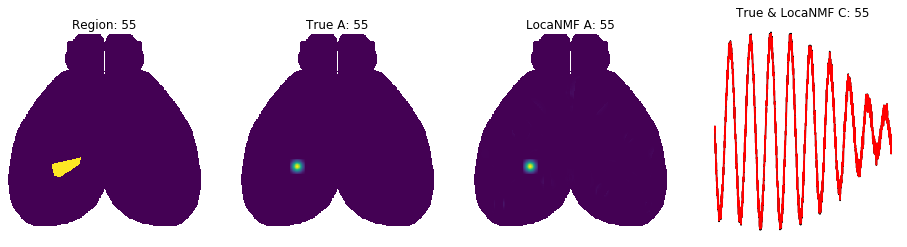

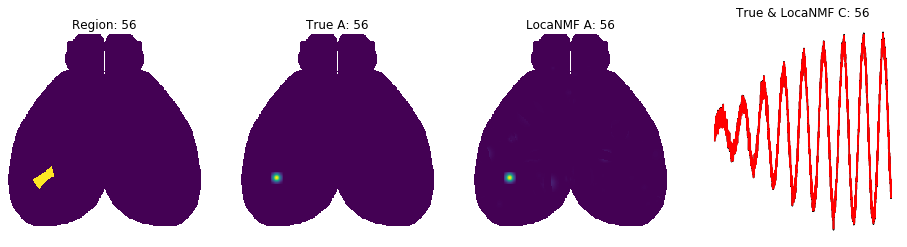

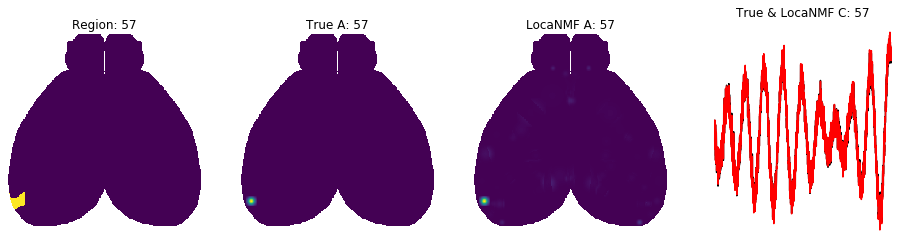

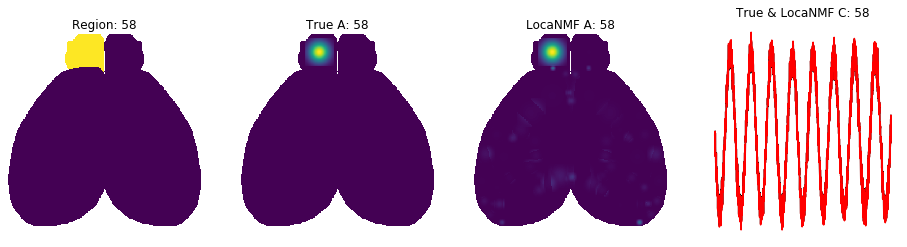

In [26]:
# Plotting all the regions' components
A_validmask=np.zeros((brainmask.shape[0],brainmask.shape[1])); A_validmask.fill(np.nan)
for rdx, i in zip(region_idx, np.cumsum(region_ranks)-1):
    fig, axs = plt.subplots(1 + int((1+region_ranks[rdx]) / 4), 4,
                            figsize=(16,(1 + int((1+region_ranks[rdx]) / 4)) * 4))
    axs = axs.reshape((int(np.prod(axs.shape)),))
    A_validmask[brainmask] = locanmf_comps.distance.data[i].cpu()==0
    axs[0].imshow(A_validmask)
    axs[0].set_title("Region: {}".format(rdx+1)); axs[0].axis('off')
    
    # only for simulated data
    A_validmask[brainmask]=video_mats[0][:,np.where(areas[i]==trueareas)[0][0]]
    axs[1].imshow(A_validmask)
    axs[1].set_title("True A: {}".format(rdx+1)); axs[1].axis('off')
    
    axs[2].imshow(A_reshape[:,:,i])
    axs[2].set_title("LocaNMF A: {}".format(i+1)); axs[2].axis('off')
    
    axs[3].plot(V[np.where(areas[i]==trueareas)[0][0],:3000].T,'k'); axs[3].plot(C[i,:3000].T,'r');
    axs[3].set_title("True & LocaNMF C: {}".format(i+1));axs[3].axis('off'); 
    if i==0: axs[3].legend(('True','LocaNMF'))
    
    plt.show()

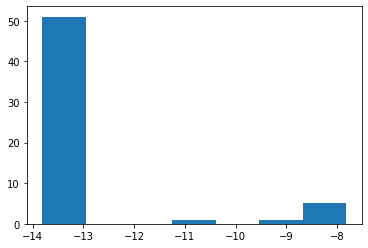

In [27]:
# Plot the distribution of lambdas. 
# If lots of values close to the minimum, decrease lambda_init.
# If lots of values close to the maximum, increase maxiter_lambda or lambda_step.
plt.hist(np.log(locanmf_comps.lambdas.data.cpu()), bins=torch.unique(locanmf_comps.lambdas.data).shape[0])
plt.show()

In [28]:
sortvec=np.argsort(np.abs(areas))
C=C[sortvec,:]
A_reshape=A_reshape[:,:,sortvec]
lambdas=np.squeeze(locanmf_comps.lambdas.data.cpu().numpy())
lambdas=lambdas[sortvec]
areas=areas[sortvec]
areainds,areanames_all = postprocess.parse_areanames(areanames)
areanames_area=[]
for i,area in enumerate(areas):
    areanames_area.append(areanames_all[areainds.index(area)])

In [32]:
sio.savemat(datafolder+'locanmf_decomp_loc'+str(loc_thresh)+'.mat',
            {'C':C,
             'A':A_reshape,
             'lambdas':locanmf_comps.lambdas.data.cpu().numpy(),
             'areas':areas,
             'r2_fit':r2_fit,
             'time_ests':time_ests,
             'areanames':areanames_area
            })

In [30]:
torch.cuda.empty_cache()

In [31]:
print("     LocaNMF completed successfully in "+ str(time.time()-t0_global) + "\n")
print("Postprocessing! \n")
postprocess.plot_components(A_reshape,C,areas,atlas,areanames,datafolder)
postprocess.plot_correlations(A_reshape,C,areas,atlas,areanames,datafolder)
print("All Done! \n")

     LocaNMF completed successfully in 199.27468705177307

Postprocessing! 

plotting components


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting correlations
All Done! 

